In [1]:
from keras import applications

from keras import optimizers 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential, Model, load_model 
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from PIL import Image
from matplotlib.pyplot import imshow
import glob
import numpy

CLASSES = ['driving license', 'financial card', 'text']
NUM_CLASSES = len(CLASSES)
DATA_PATH = '../../data/card-detection/features/'

BATCH_SIZE = 10
EPOCHS = 10
IMG_WIDTH, IMG_HEIGHT = 256, 256

MODEL_SAVE_PATH = '../../data/card-detection/models/card_detection_model_v1.h5'

def data_prep():
    features = [];
    labels = [];
    label_binarizer = preprocessing.LabelBinarizer()
    label_binarizer.fit(CLASSES)
    labels_one_hot = label_binarizer.transform(CLASSES)
    
    image_list = []
    for filename in glob.glob(DATA_PATH + 'dl/*.png'):
        image = load_img(filename, target_size=(IMG_WIDTH, IMG_HEIGHT))
        image = img_to_array(image)
        #image = image.reshape(image.shape[1], image.shape[2],image.shape[0])
        image /= 255
        features.append(image)
        labels.append(labels_one_hot[0])
    
    for filename in glob.glob(DATA_PATH + 'cc/*.png'):
        image = load_img(filename, target_size=(IMG_WIDTH, IMG_HEIGHT))
        image = img_to_array(image)
        #image = image.reshape(image.shape[1], image.shape[2],image.shape[0])
        image /= 255
        features.append(image)
        labels.append(labels_one_hot[1])
    
    for filename in glob.glob(DATA_PATH + 'text/*.png'):
        image = load_img(filename, target_size=(IMG_WIDTH, IMG_HEIGHT))
        image = img_to_array(image)
        #image = image.reshape(image.shape[1], image.shape[2],image.shape[0])
        image /= 255
        features.append(image)
        labels.append(labels_one_hot[2])
   
    features = numpy.array(features)
    #print(features.shape)
    labels = numpy.array(labels)
    #print(labels)
  
    return (features, labels)


def load_data_fn(features, labels, test_size=0.2):
    return train_test_split(features, labels, test_size=test_size, random_state=42)


#Initiate the train and test generators with data Augumentation 
# train_datagen = ImageDataGenerator(
#   rescale = 1./255,
#   horizontal_flip = True,
#   fill_mode = "nearest",
#   zoom_range = 0.3,
#   width_shift_range = 0.3,
#   height_shift_range=0.3,
#   rotation_range=30)

# test_datagen = ImageDataGenerator(
#   rescale = 1./255,
#   horizontal_flip = True,
#   fill_mode = "nearest",
#   zoom_range = 0.3,
#   width_shift_range = 0.3,
#   height_shift_range=0.3,
#   rotation_range=30)

features, labels = data_prep()

train_features, test_features, train_labels, test_labels = load_data_fn(features, labels)
print("Train count {features/labels}: %s/%s" % (len(train_features), len(train_labels)))
print("Test count {features/labels}: %s/%s" % (len(test_features), len(test_labels)))

# train_datagen.fit(train_features)
# test_datagen.fit(test_features)

Using TensorFlow backend.


Train count {features/labels}: 14/14
Test count {features/labels}: 4/4


In [2]:
def model_fn():
    initial_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))
  
    #freeze initial layers, only utilise w and b 
    for layer in initial_model.layers:
        layer.trainable = False
    
    x = initial_model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(3, activation="softmax")(x)

    # creating the final model 
    final_model = Model(input = initial_model.input, output = predictions)

    # compile the model 
    final_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])
  
    #final_model.summary()
    return final_model


def predict_fn(model, labels, image_path):
    features_predict= []
    image = load_img(image_path, target_size=(256, 256))
    %matplotlib inline
    imshow(image)
    image = img_to_array(image)
    image /= 255
    features_predict.append(image)
    features_predict = numpy.array(features_predict)
  
    prediction = model.predict(features_predict)
    
    predicted_label = CLASSES[numpy.argmax(prediction[0])]
    return predicted_label

In [3]:
model = model_fn()
#model.fit_generator(train_datagen.flow(train_features, train_labels),epochs=EPOCHS)

model.fit(train_features, train_labels, batch_size=1, epochs=EPOCHS)

#evaluate the model on test set
loss, accuracy = model.evaluate(test_features, test_labels)
print("Loss : %s   Accuracy: %s" % (loss, accuracy))

model.save(MODEL_SAVE_PATH)
del model

model = load_model(MODEL_SAVE_PATH)

80142336/80134624 [==============================] - 61s 1us/step


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


Epoch 1/10
14/14 [==============================] - 16s 1s/step - loss: 1.2328 - acc: 0.3571
Epoch 2/10
14/14 [==============================] - 15s 1s/step - loss: 1.1872 - acc: 0.5000
Epoch 3/10
14/14 [==============================] - 15s 1s/step - loss: 1.0437 - acc: 0.5714
Epoch 4/10
14/14 [==============================] - 15s 1s/step - loss: 0.9344 - acc: 0.6429
Epoch 5/10
14/14 [==============================] - 15s 1s/step - loss: 0.4668 - acc: 0.7857
Epoch 6/10
14/14 [==============================] - 15s 1s/step - loss: 0.3357 - acc: 0.8571
Epoch 7/10
14/14 [==============================] - 15s 1s/step - loss: 0.2535 - acc: 0.8571
Epoch 8/10
14/14 [==============================] - 17s 1s/step - loss: 0.2246 - acc: 0.8571
Epoch 9/10
14/14 [==============================] - 15s 1s/step - loss: 0.2041 - acc: 0.9286
Epoch 10/10
4/4 [==============================] - 4s 901ms/step
Loss : 0.6399587988853455   Accuracy: 0.75



predicted class: text


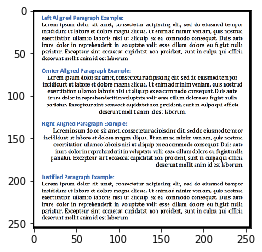

In [6]:
image_path = DATA_PATH + 'test_8.png'
predicted_label = predict_fn(model, labels, image_path)
 
print("\npredicted class: %s" % (predicted_label))